In [4]:

from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import os, random, math, time, json
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torchvision
from torchvision.transforms import functional as TF

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

BASE_DIR = Path('/content/drive/MyDrive/mp2dd')

# Training hyperparameters
CLIP_LEN = 64
FRAME_SIZE = 128      # square size (H=W)
GRAYSCALE = True      # DVS-like; will be replicated to 3 channels for pretrained model
BATCH_SIZE = 8
EPOCHS = 50
BASE_LR = 3e-4
WEIGHT_DECAY = 0.02
LABEL_SMOOTH = 0.1
WARMUP_EPOCHS = 2
EMA_DECAY = 0.999

# Sampler / split
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Loader
NUM_WORKERS = 2
PIN_MEMORY = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Checkpoints
CKPT_DIR = BASE_DIR / 'checkpoints_r3d18'
CKPT_DIR.mkdir(parents=True, exist_ok=True)
BEST_CKPT = CKPT_DIR / 'r3d18_best.pt'
HISTORY_JSON = CKPT_DIR / 'train_history.json'

print('Using device:', DEVICE)
print('Dataset root:', BASE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Dataset root: /content/drive/MyDrive/mp2dd


In [5]:

# --- Dataset scan & split ---
from sklearn.model_selection import train_test_split

def scan_dataset(root: Path, exts=('.mp4','.avi','.mov','.mkv','.MP4','.AVI','.MOV','.MKV')):
    classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
    class_to_idx = {c:i for i,c in enumerate(classes)}
    samples = []
    for c in classes:
        for p in (root / c).rglob('*'):
            if p.suffix in exts:
                samples.append((p, class_to_idx[c]))
    idx_to_class = {i:c for c,i in class_to_idx.items()}
    return samples, idx_to_class, class_to_idx

def split_dataset(samples, val_ratio=0.15, test_ratio=0.15):
    paths = [str(p) for p,_ in samples]
    labels = [y for _,y in samples]
    X_temp, X_test, y_temp, y_test = train_test_split(paths, labels, test_size=test_ratio, stratify=labels, random_state=SEED)
    val_size = val_ratio / (1.0 - test_ratio)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size, stratify=y_temp, random_state=SEED)
    def pack(X, y): return list(zip([Path(p) for p in X], y))
    return pack(X_train, y_train), pack(X_val, y_val), pack(X_test, y_test)

samples, idx2c, c2idx = scan_dataset(BASE_DIR)
assert len(samples) > 0, f'No videos found under {BASE_DIR}.'
print('Classes:', idx2c)
print('Total videos:', len(samples))

train_samples, val_samples, test_samples = split_dataset(samples, VAL_RATIO, TEST_RATIO)
print(f'Train: {len(train_samples)} | Val: {len(val_samples)} | Test: {len(test_samples)}')


Classes: {0: 'action_049', 1: 'action_050', 2: 'action_051', 3: 'action_052', 4: 'action_053', 5: 'action_054', 6: 'action_055', 7: 'action_056', 8: 'action_057', 9: 'action_058', 10: 'action_059', 11: 'action_060', 12: 'action_061', 13: 'action_062', 14: 'action_063', 15: 'action_064', 16: 'action_065', 17: 'action_066', 18: 'action_067', 19: 'action_068', 20: 'action_069', 21: 'action_070', 22: 'action_071', 23: 'action_072', 24: 'action_073', 25: 'action_074', 26: 'action_075', 27: 'action_076', 28: 'action_077', 29: 'action_078', 30: 'action_079', 31: 'action_080', 32: 'action_081', 33: 'action_082', 34: 'action_083', 35: 'action_084', 36: 'action_085', 37: 'action_086', 38: 'action_087', 39: 'action_088', 40: 'action_089', 41: 'action_090', 42: 'action_091', 43: 'action_092', 44: 'action_093', 45: 'action_094', 46: 'action_095', 47: 'action_096', 48: 'action_097', 49: 'action_098', 50: 'action_099', 51: 'action_100', 52: 'checkpoints_r3d18'}
Total videos: 7132
Train: 4992 | Val: 1

In [6]:
# --- Video I/O helpers ---

def read_video_frames(path: Path, target_frames: int, training=True):
    """Read ~target_frames with temporal jitter; loops if video is short."""
    cap = cv2.VideoCapture(str(path))
    if not cap.isOpened():
        raise RuntimeError(f'Failed to open video: {path}')
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = []

    if total <= 0:
        total = target_frames

    # segmented sampling with jitter
    seg_size = max(total // target_frames, 1)
    for i in range(target_frames):
        start = i * seg_size
        end = min((i+1)*seg_size, total) - 1
        if end < start: end = start
        if training:
            idx = random.randint(start, end) if end > start else start
        else:
            idx = (start + end) // 2
        idxs.append(idx)

    frames = []
    cur = 0
    for idx in idxs:
        # fast skip
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frame = cap.read()
        if not ok:
            # loop last good frame if short
            if len(frames) > 0:
                frame = frames[-1]
            else:
                frame = np.zeros((FRAME_SIZE, FRAME_SIZE, 3), dtype=np.uint8)
        frames.append(frame)
    cap.release()
    return frames

def to_tensor_clip(frames, grayscale=True, size=128):
    # resize & convert
    clip = []
    for fr in frames:
        if grayscale:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)  # H,W
            fr = cv2.resize(fr, (size, size), interpolation=cv2.INTER_AREA)
            fr = fr.astype(np.float32) / 255.0
            fr = (fr - 0.5) / 0.5  # normalise to [-1,1]
            fr = np.expand_dims(fr, axis=0)           # 1,H,W
            fr = np.repeat(fr, 3, axis=0)            # -> 3,H,W for pretrained
        else:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (size, size), interpolation=cv2.INTER_AREA)
            fr = fr.astype(np.float32) / 255.0
            fr = (fr - 0.5) / 0.5
            fr = np.transpose(fr, (2,0,1))           # 3,H,W
        clip.append(fr)
    clip = np.stack(clip, axis=1)  # C,T,H,W
    return torch.from_numpy(clip)

def spatial_augment(clip_tensor, training=True):
    # clip_tensor: (C,T,H,W) in [-1,1]
    C,T,H,W = clip_tensor.shape
    augmented_frames = []

    for t in range(T):
        frame = clip_tensor[:, t, :, :].unsqueeze(0)  # 1, C, H, W

        if training:
            # random resized crop
            scale = random.uniform(0.7, 1.0)
            new_h, new_w = int(H * scale), int(W * scale)
            i = random.randint(0, H - new_h)
            j = random.randint(0, W - new_w)
            frame = frame[:, :, i : i + new_h, j : j + new_w]
            frame = torch.nn.functional.interpolate(frame, size=(FRAME_SIZE, FRAME_SIZE), mode='bilinear', align_corners=False)

            # random horizontal flip
            if random.random() < 0.5:
                frame = torch.flip(frame, dims=[3])  # W

            # small random rotation
            if random.random() < 0.3:
                angle = random.uniform(-5, 5)
                grid = torch.nn.functional.affine_grid(
                    torch.tensor([[[math.cos(math.radians(angle)), -math.sin(math.radians(angle)), 0],
                                   [math.sin(math.radians(angle)),  math.cos(math.radians(angle)), 0]]], dtype=frame.dtype, device=frame.device),
                    size=(1, C, FRAME_SIZE, FRAME_SIZE), align_corners=False
                )
                frame = torch.nn.functional.grid_sample(frame, grid, align_corners=False, mode='bilinear', padding_mode='zeros')
        else:
            # centre crop to FRAME_SIZE (no-op if already FRAME_SIZE)
             frame = torch.nn.functional.interpolate(frame, size=(FRAME_SIZE, FRAME_SIZE), mode='bilinear', align_corners=False)

        augmented_frames.append(frame.squeeze(0)) # remove batch dim

    return torch.stack(augmented_frames, dim=1) # C,T,H,W

In [7]:

# --- PyTorch Dataset ---

class VideoClipDataset(Dataset):
    def __init__(self, samples, clip_len=32, frame_size=128, grayscale=True, training=True):
        self.samples = samples
        self.clip_len = clip_len
        self.frame_size = frame_size
        self.grayscale = grayscale
        self.training = training

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        frames = read_video_frames(path, self.clip_len, training=self.training)
        clip = to_tensor_clip(frames, grayscale=self.grayscale, size=self.frame_size)  # (3,T,H,W)
        clip = spatial_augment(clip, training=self.training)  # keep (3,T,H,W)
        return clip, label


In [8]:

# --- DataLoaders & optional class balancing ---

def make_loaders(train_samples, val_samples, test_samples):
    # Optional: balance sampler for train
    labels = [y for _,y in train_samples]
    class_counts = np.bincount(labels)
    class_weights = 1.0 / (class_counts + 1e-9)
    sample_weights = [class_weights[y] for y in labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_ds = VideoClipDataset(train_samples, clip_len=CLIP_LEN, frame_size=FRAME_SIZE, grayscale=GRAYSCALE, training=True)
    val_ds   = VideoClipDataset(val_samples,   clip_len=CLIP_LEN, frame_size=FRAME_SIZE, grayscale=GRAYSCALE, training=False)
    test_ds  = VideoClipDataset(test_samples,  clip_len=CLIP_LEN, frame_size=FRAME_SIZE, grayscale=GRAYSCALE, training=False)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = make_loaders(train_samples, val_samples, test_samples)
print('Batches -> train:', len(train_loader), 'val:', len(val_loader), 'test:', len(test_loader))


Batches -> train: 624 val: 134 test: 134


In [9]:

# --- Model: Pretrained R3D-18 ---

from torchvision.models.video import r3d_18, R3D_18_Weights

num_classes = len(idx2c)

# Load pretrained weights (Kinetics-400)
weights = R3D_18_Weights.DEFAULT
backbone = r3d_18(weights=weights)
# Replace final classifier
in_feat = backbone.fc.in_features
backbone.fc = nn.Linear(in_feat, num_classes)

model = backbone.to(DEVICE)

# Loss & optimiser
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optim = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)

# Cosine schedule with warmup
def cosine_lr(base_lr, step, total_steps, warmup_steps=0):
    if step < warmup_steps:
        return base_lr * float(step+1) / float(max(1,warmup_steps))
    progress = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return max(1e-6, base_lr * 0.5 * (1.0 + math.cos(math.pi * progress)))

total_steps = EPOCHS * len(train_loader)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# EMA
import copy
ema_model = copy.deepcopy(model).to(DEVICE)
for p in ema_model.parameters(): p.requires_grad_(False)
def update_ema(ema_model, model, decay=EMA_DECAY):
    with torch.no_grad():
        msd = model.state_dict()
        for k,v in ema_model.state_dict().items():
            if k in msd:
                ema_model.state_dict()[k].copy_(decay*v + (1.0 - decay)*msd[k])


Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth


100%|██████████| 127M/127M [00:00<00:00, 224MB/s]
/tmp/ipython-input-3939391593.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [10]:

# --- Train / Validate ---

def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

history = {'epoch':[], 'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
best_val_acc = 0.0

global_step = 0
for epoch in range(1, EPOCHS+1):
    model.train()
    t0 = time.time()
    train_loss = 0.0; train_acc = 0.0; n_batches = 0

    for clips, labels in train_loader:
        clips = clips.to(DEVICE, non_blocking=True)
        labels = torch.as_tensor(labels, device=DEVICE)

        # r3d expects N,C,T,H,W
        lr_now = cosine_lr(BASE_LR, global_step, total_steps, warmup_steps=WARMUP_EPOCHS*len(train_loader))
        for g in optim.param_groups: g['lr'] = lr_now

        optim.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(clips)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optim)
        scaler.update()

        update_ema(ema_model, model, EMA_DECAY)

        train_loss += loss.item()
        train_acc  += accuracy_from_logits(logits.detach(), labels)
        n_batches  += 1
        global_step += 1

    train_loss /= max(1,n_batches)
    train_acc  /= max(1,n_batches)

    # Validation (use EMA weights)
    ema_model.eval()
    val_loss = 0.0; val_acc = 0.0; n_valb = 0
    with torch.no_grad():
        for clips, labels in val_loader:
            clips = clips.to(DEVICE, non_blocking=True)
            labels = torch.as_tensor(labels, device=DEVICE)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = ema_model(clips)
                loss = criterion(logits, labels)
            val_loss += loss.item()
            val_acc  += accuracy_from_logits(logits, labels)
            n_valb   += 1
    val_loss /= max(1,n_valb)
    val_acc  /= max(1,n_valb)

    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    with open(HISTORY_JSON, 'w') as f:
        json.dump(history, f, indent=2)

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS}  time {dt:.1f}s | train loss {train_loss:.4f} acc {train_acc:.3f} | val loss {val_loss:.4f} acc {val_acc:.3f} | lr {lr_now:.2e}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model': ema_model.state_dict(),
                    'idx2c': idx2c,
                    'cfg': {'FRAME_SIZE':FRAME_SIZE, 'CLIP_LEN':CLIP_LEN, 'GRAYSCALE':GRAYSCALE}}, BEST_CKPT)
        print('  ↳ New best model saved:', BEST_CKPT)


/tmp/ipython-input-3369319810.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-3369319810.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 01/50  time 3450.7s | train loss 3.7327 acc 0.090 | val loss 3.9974 acc 0.022 | lr 1.50e-04
  ↳ New best model saved: /content/drive/MyDrive/mp2dd/checkpoints_r3d18/r3d18_best.pt
Epoch 02/50  time 1688.4s | train loss 2.9120 acc 0.286 | val loss 4.0410 acc 0.017 | lr 3.00e-04
Epoch 03/50  time 1296.2s | train loss 2.4371 acc 0.422 | val loss 4.1116 acc 0.018 | lr 3.00e-04
Epoch 04/50  time 1135.5s | train loss 2.0377 acc 0.563 | val loss 4.1574 acc 0.018 | lr 2.99e-04
Epoch 05/50  time 1030.0s | train loss 1.8499 acc 0.621 | val loss 4.1320 acc 0.022 | lr 2.97e-04
Epoch 06/50  time 1006.5s | train loss 1.7708 acc 0.651 | val loss 3.9225 acc 0.047 | lr 2.95e-04
  ↳ New best model saved: /content/drive/MyDrive/mp2dd/checkpoints_r3d18/r3d18_best.pt
Epoch 07/50  time 1009.0s | train loss 1.8848 acc 0.601 | val loss 3.5420 acc 0.113 | lr 2.92e-04
  ↳ New best model saved: /content/drive/MyDrive/mp2dd/checkpoints_r3d18/r3d18_best.pt
Epoch 08/50  time 1009.3s | train loss 1.7175 acc 0.6

Test Top-1 Accuracy: 0.691

Classification report:
              precision    recall  f1-score   support

  action_049       0.42      0.36      0.39        22
  action_050       0.82      0.64      0.72        22
  action_051       0.53      0.48      0.50        21
  action_052       0.56      0.71      0.62        21
  action_053       0.67      0.86      0.75        21
  action_054       0.78      0.67      0.72        21
  action_055       0.89      0.81      0.85        21
  action_056       0.44      0.67      0.53        21
  action_057       0.63      0.57      0.60        21
  action_058       0.27      0.41      0.33        22
  action_059       0.57      0.57      0.57        21
  action_060       0.53      0.48      0.50        21
  action_061       0.73      0.52      0.61        21
  action_062       0.88      0.67      0.76        21
  action_063       0.75      0.57      0.65        21
  action_064       0.69      0.52      0.59        21
  action_065       0.75      0

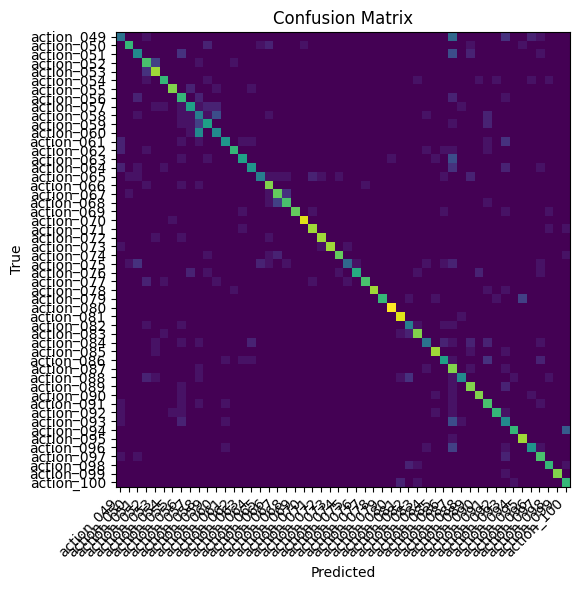

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load mapping from checkpoint (keeps names aligned with the trained model)
ckpt = torch.load(BEST_CKPT, map_location=DEVICE)
if 'idx2c' in ckpt:
    idx2c = ckpt['idx2c']
ema_model.load_state_dict(ckpt['model'])
ema_model.eval()

y_true_all, y_pred_all = [], []
with torch.no_grad():
    for clips, labels in test_loader:
        clips = clips.to(DEVICE, non_blocking=True)
        labels = torch.as_tensor(labels, device=DEVICE)
        logits = ema_model(clips)
        preds = logits.argmax(dim=1)
        y_true_all.extend(labels.cpu().tolist())
        y_pred_all.extend(preds.cpu().tolist())

acc = np.mean(np.array(y_true_all) == np.array(y_pred_all))
print(f'Test Top-1 Accuracy: {acc:.3f}')

# --- Only use labels that are present ---
labels_present = sorted(set(y_true_all) | set(y_pred_all))
names_present  = [idx2c[i] for i in labels_present]

print('\nClassification report:')
print(classification_report(y_true_all, y_pred_all,
                            labels=labels_present,
                            target_names=names_present,
                            zero_division=0))

# Confusion matrix using the same labels
cm = confusion_matrix(y_true_all, y_pred_all, labels=labels_present)
fig = plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.xticks(range(len(labels_present)), names_present, rotation=45, ha='right')
plt.yticks(range(len(labels_present)), names_present)
plt.tight_layout()
plt.show()


In [12]:

# --- Multi-clip TTA prediction + CSV export ---
import csv

def predict_video_multiclip(model, path: Path, idx2c, nclips=5):
    model.eval()
    probs_sum = None
    with torch.no_grad():
        for i in range(nclips):
            frames = read_video_frames(path, CLIP_LEN, training=True)  # jittered
            clip = to_tensor_clip(frames, grayscale=GRAYSCALE, size=FRAME_SIZE)
            clip = spatial_augment(clip, training=False)  # deterministic resize/centre
            clip = clip.unsqueeze(0).to(DEVICE)  # N,C,T,H,W
            logits = model(clip)
            probs = F.softmax(logits, dim=1).cpu().numpy()[0]
            probs_sum = probs if probs_sum is None else (probs_sum + probs)
    probs_mean = probs_sum / float(nclips)
    top_idx = probs_mean.argsort()[::-1]
    return [(idx2c[i], float(probs_mean[i])) for i in top_idx[:5]]

def export_predictions_csv(model, samples, idx2c, out_csv: Path, nclips=5):
    model.eval()
    with open(out_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        header = ['video', 'true_label', 'pred_label', 'correct']
        writer.writerow(header)
        with torch.no_grad():
            for p, y_true in samples:
                top5 = predict_video_multiclip(model, p, idx2c, nclips=nclips)
                pred_idx = [k for k,v in idx2c.items() if v == top5[0][0]][0]
                writer.writerow([str(p), idx2c[y_true], top5[0][0], int(pred_idx==y_true)])
    print(f'Saved CSV: {out_csv}')

# Example usage:
# out_csv = BASE_DIR / 'test_predictions_r3d18.csv'
# export_predictions_csv(ema_model, test_samples, idx2c, out_csv, nclips=7)



## Tips for even better results

- **Longer clips**: increase `CLIP_LEN` to 48 or 64 if VRAM allows.
- **Higher resolution**: bump `FRAME_SIZE` to 160 or 192.
- **Frozen backbone warm-up**: freeze all but `fc` for 3–5 warm-up epochs, then unfreeze.
- **Two-stream**: add a *frame-difference* stream and fuse (sum/concat) logits.
- **More augmentation**: try random brightness/contrast and Cutout (for DVS it’s usually fine).
- **Training time**: go 60–100 epochs with cosine schedule and early stopping.
